# Assignment 9 Math Foundations Machine Learning
## David Alvear 187594

In [36]:
import torch
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## 1. Embedding via Feedforward network
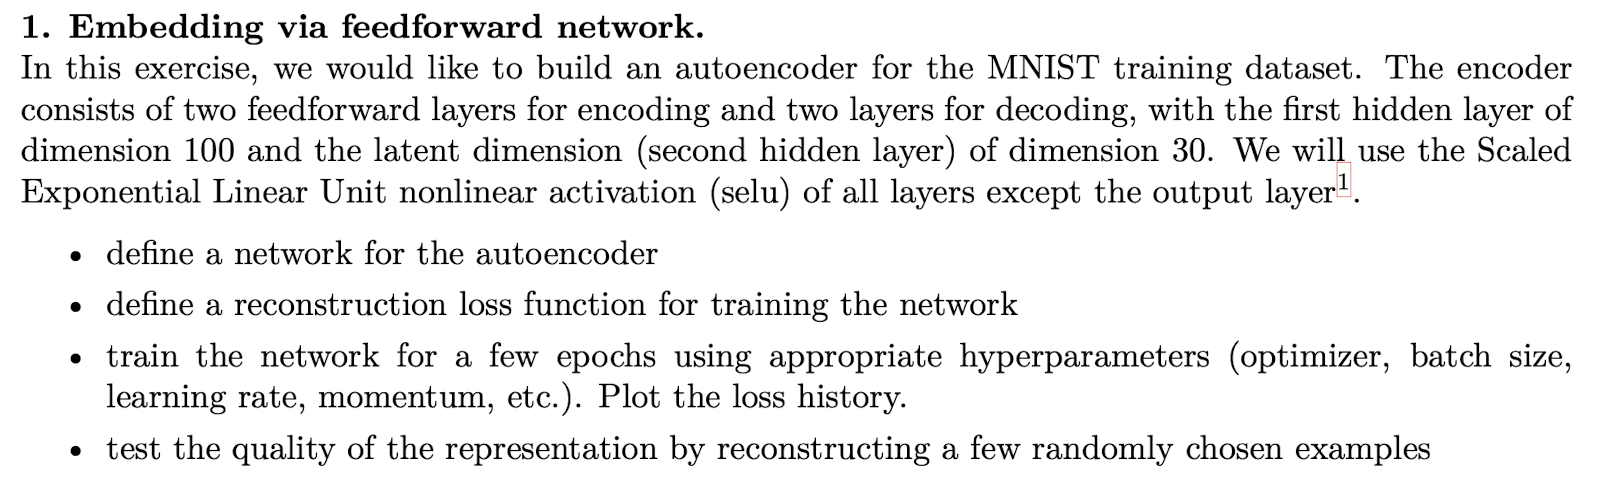

In [27]:
##########################################
######## Training Functions ##############
##########################################


def evaluate_model(model, dataloader, device):
    # Function that takes the model and evaluate in the test dataloader
    # return the predicted data for multi-class classification
    model.eval()
    model.to(device)
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.float)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    return all_predictions, all_targets

def one_epoch(model, dataloader, criterion, optimizer=None, training=True, device='cpu'):
    """Perform one epoch"""
    total_loss = 0.0
    model.to(device)
    with torch.set_grad_enabled(training):
        if training:
            model.train()
        else:
            model.eval()

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.float)
            prediction = model(inputs).squeeze()
            loss = criterion(prediction, targets)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()  # get the scalar value of the loss tensor

    return total_loss / len(dataloader)

def train(epochs, model, optimizer, criterion, train_dataloader, eval_dataloader, device):
    logs = []
    for epoch in range(epochs):
        # Run training
        train_loss_epoch = one_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer,
            training=True,
            device=device
        )

        # Run evaluation
        eval_loss_epoch = one_epoch(
            model,
            eval_dataloader,
            criterion,
            optimizer=None,  # No optimizer for evaluation
            training=False,
            device=device
        )

        logs.append((train_loss_epoch, eval_loss_epoch))
        print(f"Epoch: {epoch}, Training Loss Avg: {train_loss_epoch:.4f}, Eval Loss Avg: {eval_loss_epoch:.4f}")
    return logs

##########################################
############## Plot semilog ##############
##########################################

def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(12, 6))
    plt.semilogy(train_loss, label='Training Loss')
    plt.semilogy(test_loss, label='Testing Loss')
    ymin, ymax = plt.ylim()  # Get current y-axis limits
    yticks = np.linspace(ymin, ymax, num=10)  # Create 10 equally spaced ticks
    plt.yticks(yticks)  # Set custom y-ticks
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

##########################################
######### Confussion Matrix ##############
##########################################

def visualize_confusion_matrix(test_labels, test_predicted_labels, labels=[1,0]):
    print("\nCONFUSSION MATRIX\n")
    conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def visualize_classification_report(test_labels, test_predicted_labels, labels=[1,0]):
    # Generate the test classification report
    print("\nCLASSIFICATION REPORT\n")
    report = classification_report(test_labels, test_predicted_labels, target_names=labels)
    print(report)

In [19]:
# read MNIST training data
df = pd.read_csv('./mnist_train.csv')
df_test = pd.read_csv('./mnist_test.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0
X_test = df_test.iloc[:, 1:].to_numpy() / 255.0   # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()
y_test = df_test.iloc[:, 0].to_numpy() # labels of images

# Give format
X = torch.tensor(X, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.int64)
# y_test = torch.tensor(y_test, dtype=torch.int64)

# Create Datasets and Dataloaders
batch_size = 32
train_dataset = TensorDataset(X, X)
test_dataset = TensorDataset(X_test, X_test)
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [20]:
# Model
class AutoencoderMNIST(nn.Module):
    def __init__(self):
        super(AutoencoderMNIST, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.SELU(),
            nn.Linear(100, 30),
            nn.SELU()
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.SELU(),
            nn.Linear(100, 28 * 28),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
# Define the model
autoen_model = AutoencoderMNIST()
# criterion
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(autoen_model.parameters(), lr=2e-3)
# Training
logs = train(15, autoen_model, optimizer, criterion, train_dataloader, test_dataloader, 'cpu')

Epoch: 0, Training Loss Avg: 0.0216, Eval Loss Avg: 0.0185
Epoch: 1, Training Loss Avg: 0.0186, Eval Loss Avg: 0.0178
Epoch: 2, Training Loss Avg: 0.0179, Eval Loss Avg: 0.0172
Epoch: 3, Training Loss Avg: 0.0172, Eval Loss Avg: 0.0165
Epoch: 4, Training Loss Avg: 0.0167, Eval Loss Avg: 0.0161
Epoch: 5, Training Loss Avg: 0.0163, Eval Loss Avg: 0.0159
Epoch: 6, Training Loss Avg: 0.0159, Eval Loss Avg: 0.0156
Epoch: 7, Training Loss Avg: 0.0157, Eval Loss Avg: 0.0152
Epoch: 8, Training Loss Avg: 0.0155, Eval Loss Avg: 0.0150
Epoch: 9, Training Loss Avg: 0.0153, Eval Loss Avg: 0.0149
Epoch: 10, Training Loss Avg: 0.0152, Eval Loss Avg: 0.0149
Epoch: 11, Training Loss Avg: 0.0150, Eval Loss Avg: 0.0147
Epoch: 12, Training Loss Avg: 0.0149, Eval Loss Avg: 0.0144
Epoch: 13, Training Loss Avg: 0.0148, Eval Loss Avg: 0.0143
Epoch: 14, Training Loss Avg: 0.0147, Eval Loss Avg: 0.0144


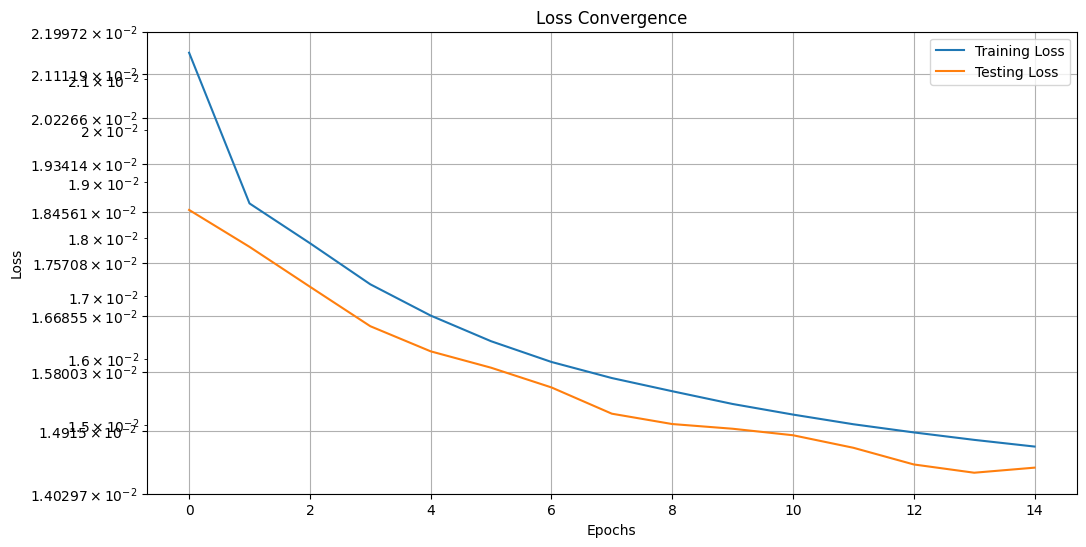

In [22]:
# visualize results
loss_values = np.array(logs)
plot_loss(loss_values[:,0], loss_values[:,1])

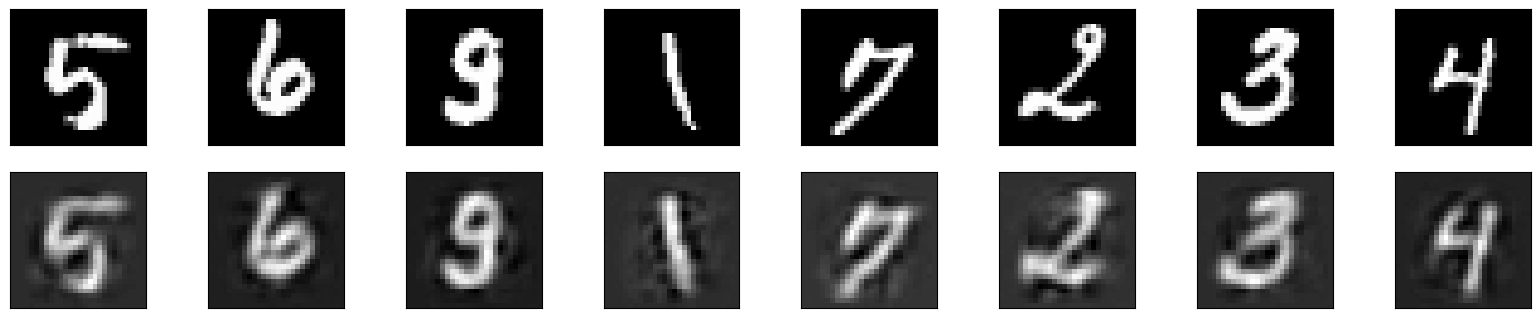

In [23]:
# plot examples
autoen_model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        # inputs = inputs.to(device)
        outputs = autoen_model(inputs)
        break

plt.figure(figsize=(20, 6))
n_images = 8

for i in range(n_images):
    # Display original images
    ax = plt.subplot(3, n_images, i + 1)
    plt.imshow(inputs[i].reshape(28, 28), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(outputs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Using an autoencoder designed using feed forward layers give the possibility to have an understandable reconstruction of the dataset. We can see that the numbers have a smooth transition between the background an the number. Seems that the edges are not well understood in the model, but it can be improved using convolutional models that understand visual representations.

## 2. Embedding via CNN network
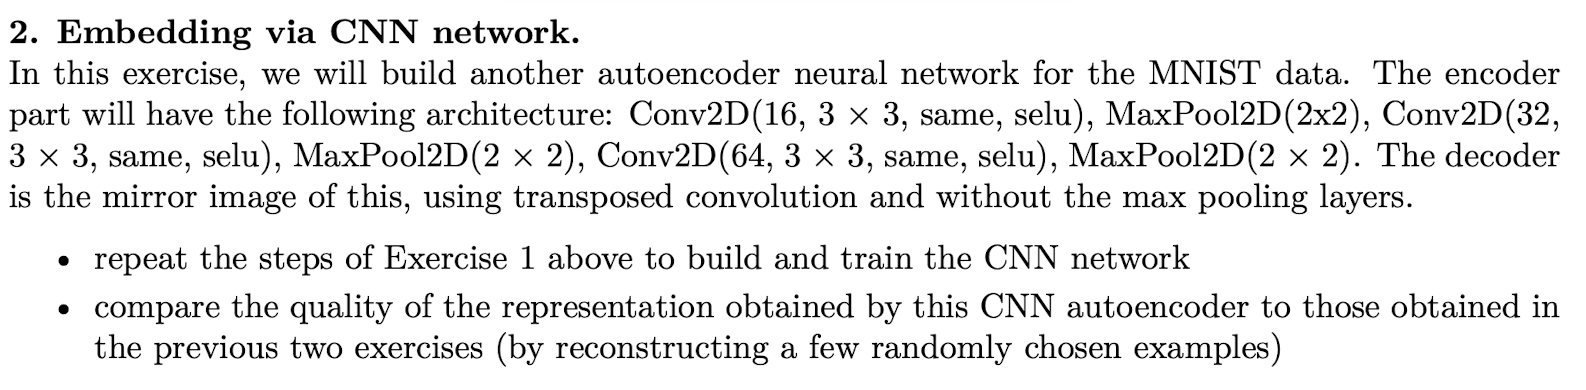

In [34]:
# Model
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.SELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.SELU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1),
            nn.SELU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.SELU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [35]:
# read MNIST training data
df = pd.read_csv('./mnist_train.csv')
df_test = pd.read_csv('./mnist_test.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0
X_test = df_test.iloc[:, 1:].to_numpy() / 255.0   # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()
y_test = df_test.iloc[:, 0].to_numpy() # labels of images

# Give format
X = torch.tensor(X.reshape(-1, 1, 28, 28), dtype=torch.float32)
X_test = torch.tensor(X_test.reshape(-1, 1, 28, 28), dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.int64)
# y_test = torch.tensor(y_test, dtype=torch.int64)

# Create Datasets and Dataloaders
batch_size = 128
train_dataset = TensorDataset(X, X)
test_dataset = TensorDataset(X_test, X_test)
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [37]:
device = 'cuda'
model = CNNAutoencoder().to(device=device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

n_epochs = 20
loss_history = []
val_history = []

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_dataloader)
    loss_history.append(average_epoch_loss)

    if epoch % 5 == 0:
        print(f"/n Epoch {epoch} | Training Loss: {average_epoch_loss:.5f}")

  5%|▌         | 1/20 [00:04<01:24,  4.43s/it]

Epoch 0 | Training Loss: 0.02402


 30%|███       | 6/20 [00:29<01:09,  4.95s/it]

Epoch 5 | Training Loss: 0.00472


 55%|█████▌    | 11/20 [00:57<00:47,  5.31s/it]

Epoch 10 | Training Loss: 0.00353


 80%|████████  | 16/20 [01:21<00:19,  4.76s/it]

Epoch 15 | Training Loss: 0.00311


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


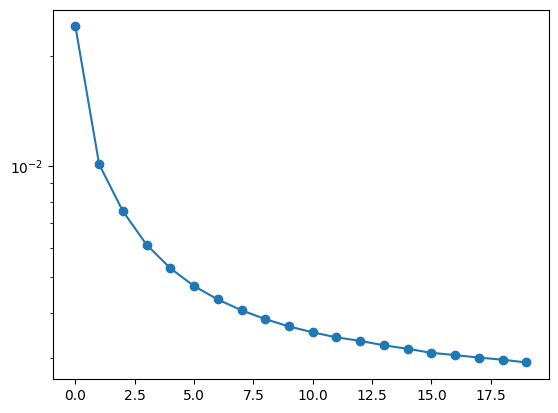

In [38]:
plt.semilogy(loss_history, 'o-')

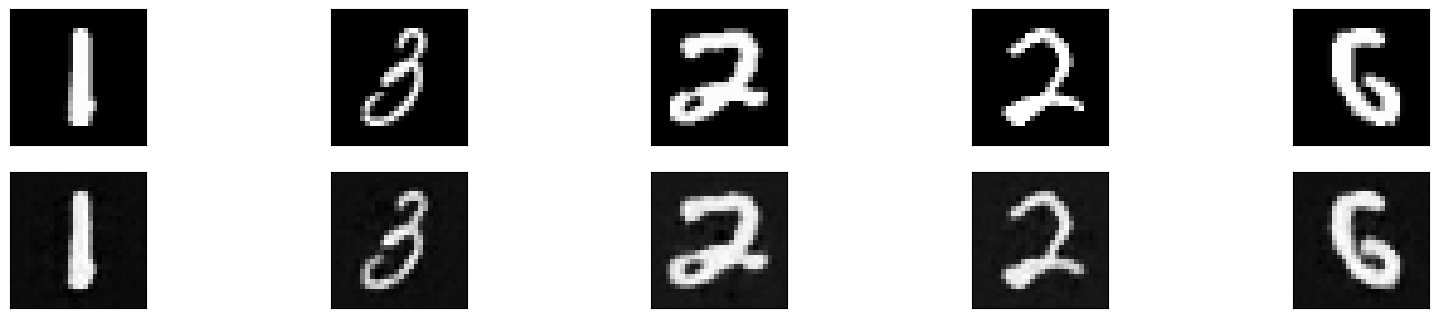

In [41]:
# plot examples
model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        break

inputs = inputs.cpu()
outputs = outputs.cpu()

plt.figure(figsize=(20, 6))
n_images = 5

for i in range(n_images):
    # Display original images
    ax = plt.subplot(3, n_images, i + 1)
    plt.imshow(inputs[i].reshape(28, 28), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(outputs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Using CNN for the autoencoder model improve the result of the reconstructions. In this case the receptive field of the convolutions make possible to understand edges, shapes, and more complex visual representations of the images. That's why we have a more defined edges in the reconstructions. The improvement of the model from only using feed forward approaches to convolutions is notable.

## 4. Recurrent Network
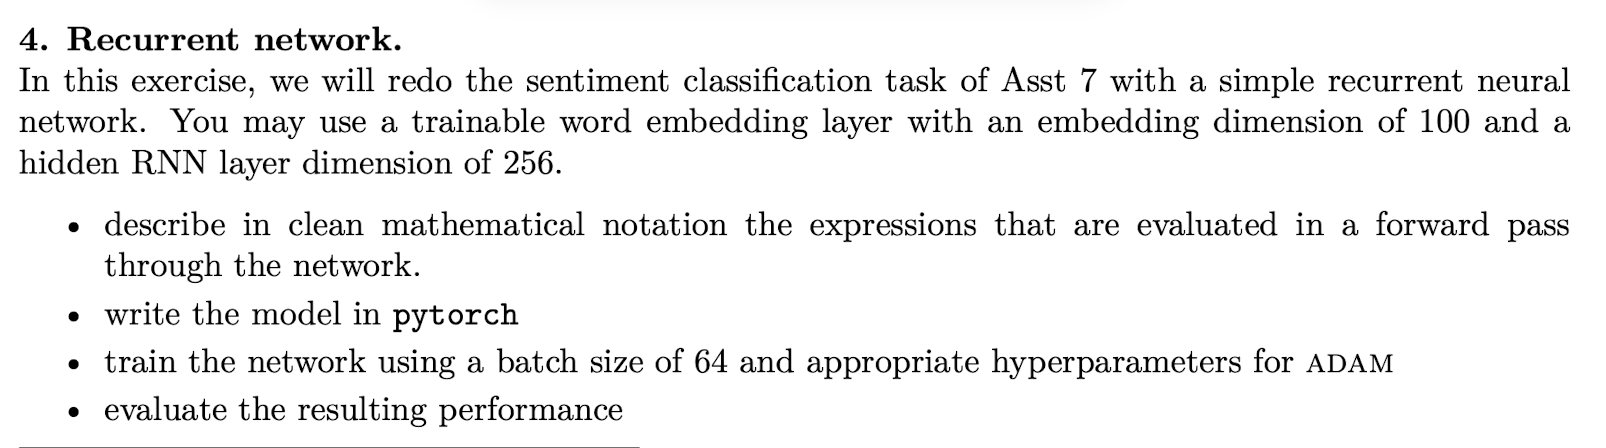

In [3]:
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchinfo import summary

# download or read from cache IMDb data
train_data = list(IMDB(split='train'))
test_data = list(IMDB(split='test'))

# download or read from cache word embeddings
vectors = torchtext.vocab.GloVe(name='6B', dim=50, max_vectors=100_000)

# build the vocabulary---all words in training data
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for (label, line) in train_data:
    counter.update(tokenizer(line))
counter = dict(counter.most_common())
vocab = torchtext.vocab.vocab(counter, min_freq=10, specials=('<PAD>', '<unk>'))
vocab.set_default_index(vocab['<unk>'])

print("Vocabulary size: ", len(vocab))
print(train_data[0][1])   # print the text of first review

# takes in a review (string), returns a vector of indices (maxlength T)
def text_transform(x, T=256):
    indices = [vocab[token] for token in tokenizer(x)]
    return indices[:256] if len(indices) > T else indices + [0] * (T-len(indices))

# takes in the sentiment, returns 1/0 labels (1 for positive review)
def label_transform(x):
    return 1 if x == 2 else 0

# returns X, y tensors from training data
def create_tensors(train_data):
    label_list, text_list = [], []
    for idx, (label, text) in enumerate(train_data):
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text))
        text_list.append(processed_text)
    return torch.stack(text_list), torch.tensor(label_list)

Vocabulary size:  20437
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are 

In [28]:
# model
class RecurrentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RecurrentModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNNCell(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(batch_size, self.hidden_dim)

        x = x.to(torch.long)
        x = self.embed(x)

        for t in range(x.size(1)):
            hidden = self.rnn(x[:, t, :], hidden)

        out = self.linear(hidden)
        return out

In [21]:
# Define data
X, y = create_tensors(train_data)

dataset = TensorDataset(X, y)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

X_t, y_t = create_tensors(test_data)
dataset_test = TensorDataset(X_t, y_t)
test_dataloader = DataLoader(dataset_test, batch_size=64, shuffle=False)

In [29]:
# define model
model = RecurrentModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=256, output_dim=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Example summary
summary(model, input_size=(10, 256))

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentModel                           [10, 1]                   --
├─Embedding: 1-1                         [10, 256, 100]            2,043,700
├─RNNCell: 1-2                           [10, 256]                 91,648
├─RNNCell: 1-3                           [10, 256]                 (recursive)
├─RNNCell: 1-4                           [10, 256]                 (recursive)
├─RNNCell: 1-5                           [10, 256]                 (recursive)
├─RNNCell: 1-6                           [10, 256]                 (recursive)
├─RNNCell: 1-7                           [10, 256]                 (recursive)
├─RNNCell: 1-8                           [10, 256]                 (recursive)
├─RNNCell: 1-9                           [10, 256]                 (recursive)
├─RNNCell: 1-10                          [10, 256]                 (recursive)
├─RNNCell: 1-11                          [10, 256]                 (recu

In [30]:
# Train
logs = train(20, model, optimizer, criterion, train_dataloader, test_dataloader, 'cpu')

Epoch: 0, Training Loss Avg: 0.6983, Eval Loss Avg: 0.6960
Epoch: 1, Training Loss Avg: 0.6960, Eval Loss Avg: 0.7253
Epoch: 2, Training Loss Avg: 0.6977, Eval Loss Avg: 0.6936
Epoch: 3, Training Loss Avg: 0.6925, Eval Loss Avg: 0.6965
Epoch: 4, Training Loss Avg: 0.6855, Eval Loss Avg: 0.6985
Epoch: 5, Training Loss Avg: 0.6753, Eval Loss Avg: 0.6972
Epoch: 6, Training Loss Avg: 0.6612, Eval Loss Avg: 0.6980
Epoch: 7, Training Loss Avg: 0.6474, Eval Loss Avg: 0.7114
Epoch: 8, Training Loss Avg: 0.6322, Eval Loss Avg: 0.7199
Epoch: 9, Training Loss Avg: 0.6216, Eval Loss Avg: 0.7253
Epoch: 10, Training Loss Avg: 0.6133, Eval Loss Avg: 0.7322
Epoch: 11, Training Loss Avg: 0.6095, Eval Loss Avg: 0.7398
Epoch: 12, Training Loss Avg: 0.5994, Eval Loss Avg: 0.7569
Epoch: 13, Training Loss Avg: 0.5858, Eval Loss Avg: 0.7342
Epoch: 14, Training Loss Avg: 0.5833, Eval Loss Avg: 0.7629
Epoch: 15, Training Loss Avg: 0.5733, Eval Loss Avg: 0.7735
Epoch: 16, Training Loss Avg: 0.5695, Eval Loss Av

<ipython-input-37-0d75da1f9b41>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = torch.sigmoid(model(torch.tensor(X_t))).round()



CONFUSSION MATRIX



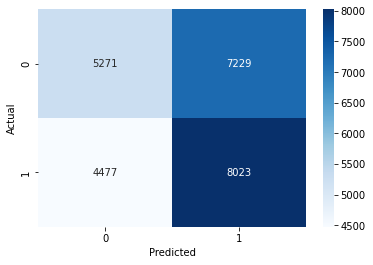


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.54      0.42      0.47     12500
           1       0.53      0.64      0.58     12500

    accuracy                           0.53     25000
   macro avg       0.53      0.53      0.53     25000
weighted avg       0.53      0.53      0.53     25000



In [37]:
model.eval()

with torch.no_grad():
    test_predictions = torch.sigmoid(model(torch.tensor(X_t))).round()

visualize_confusion_matrix(y_t, test_predictions, labels=['0','1'])
visualize_classification_report(y_t, test_predictions, labels=['0','1'])

The classification report and the confusion matrix show that the model has a poor performance. One improvement that could increase the accuracy of the model is using pretrained embeddings.